# Opening NetCDF files with xarray

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import datetime

**Open the GPCP precipitation reanalysis data set (monthly globally gridded precipitation data during 1979-present day):**

In [2]:
filename = '../data/precip.mon.mean.nc' # gpcp data set

ncfile = xr.open_dataset(filename)
type(ncfile)

xarray.core.dataset.Dataset

In [3]:
print(ncfile)

<xarray.Dataset>
Dimensions:    (lat: 72, lon: 144, nv: 2, time: 480)
Coordinates:
  * lat        (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float32 1.25 3.75 6.25 8.75 ... 351.25 353.75 356.25 358.75
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) datetime64[ns] ...
    lat_bnds   (lat, nv) float32 ...
    lon_bnds   (lon, nv) float32 ...
    precip     (time, lat, lon) float32 ...
Attributes:
    Conventions:           CF-1.0
    curator:               Dr. Jian-Jian Wang\nESSIC, University of Maryland ...
    citation:              Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P...
    title:                 GPCP Version 2.3 Combined Precipitation Dataset (F...
    platform:              NOAA POES (Polar Orbiting Environmental Satellites)
    source_obs:            CDR RSS SSMI/SSMIS Tbs over ocean \nCDR SSMI/SSMIS...
    documentation:  

**Extract a given data variable using the familiar dictionary syntax, ```dict['var']```.**  
Note: The actual values do not get loaded at this point; you must explicitly ask for the ```.values``` as a numpy array for the data to be loaded into memory.

In [4]:
precip_da = ncfile['precip']
print(precip_da)

<xarray.DataArray 'precip' (time: 480, lat: 72, lon: 144)>
[4976640 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 ... 351.25 353.75 356.25 358.75
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
Attributes:
    long_name:     Average Monthly Rate of Precipitation
    valid_range:   [  0. 100.]
    units:         mm/day
    precision:     32767
    var_desc:      Precipitation
    dataset:       GPCP Version 2.3 Combined Precipitation Dataset
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Mean
    actual_range:  [0.00000e+00 9.96921e+36]


**Get time variable the same way:**

In [5]:
time_da = ncfile['time']
print(time_da)

<xarray.DataArray 'time' (time: 480)>
array(['1979-01-01T00:00:00.000000000', '1979-02-01T00:00:00.000000000',
       '1979-03-01T00:00:00.000000000', ..., '2018-10-01T00:00:00.000000000',
       '2018-11-01T00:00:00.000000000', '2018-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
Attributes:
    long_name:      Time
    delta_t:        0000-01-00 00:00:00
    avg_period:     0000-01-00 00:00:00
    standard_name:  time
    axis:           T
    actual_range:   [65378. 79957.]


**NOTE:  The time variable in xarray is typically imported as a numpy ```datetime64[ns]``` object, which can be less intuitive to work with if you're used to the datetime objects within pandas.  There's a handy pandas function that helps solve this:**

In [6]:
time_values = time_da.values
time_values_converted = pd.to_datetime(time_values)

In [7]:
print(time_values[0])
print(time_values_converted[0])

1979-01-01T00:00:00.000000000
1979-01-01 00:00:00


**Use the familiar ```.sel()``` method to pull out a specific month and plot it using the built-in ```.plot()``` syntax of xarray:**

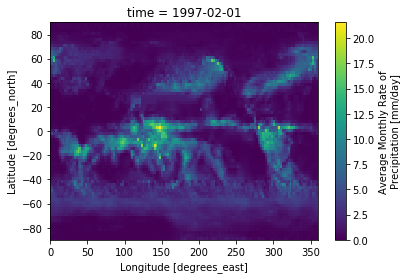

In [8]:
precip_da.sel(time='1997-02-01').plot()

**Calculate seasonal means quickly using the familiar ```groupby()``` syntax seen in pandas.**

Note these are not weighted by month length; see the [xarray documentation](http://xarray.pydata.org/en/stable/examples/monthly-means.html) for an example of how to do this.

In [9]:
precip_da_season = precip_da.groupby('time.season').mean(dim='time')
#print(precip_da_season)

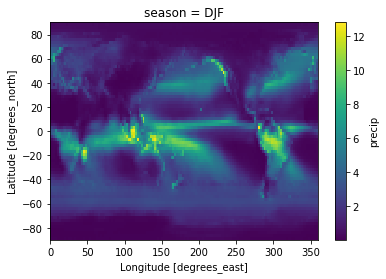

In [10]:
precip_da_season.sel(season='DJF').plot()

**Extract values from a DataArray or DataSet using the ```.values``` syntax:**

In [11]:
# get the data out of this using:
precip_djf = precip_da_season.sel(season='DJF').values
print(precip_djf.shape) # print the shape of the array - note its dimensions
print()
print(precip_djf) # print subset of the data

(72, 144)

[[0.04973946 0.05181365 0.05536408 ... 0.04372016 0.04819309 0.04534511]
 [0.03554448 0.03699839 0.0398022  ... 0.04077363 0.04093347 0.04236748]
 [0.04748641 0.04995316 0.04277738 ... 0.05515544 0.05457157 0.04645221]
 ...
 [0.55864817 0.5579807  0.55738324 ... 0.54878235 0.5391298  0.5555    ]
 [0.44432628 0.4512153  0.441662   ... 0.43562454 0.44467676 0.44131768]
 [0.39938933 0.38825503 0.38279334 ... 0.40465572 0.3989903  0.38911375]]


## Subselecting, manipulating, and plotting data

** Pick out the grid box closest to Irvine, and plot only the DJF means of precipitation over time. **

See the [xarray documentation on indexing and selecting data](http://xarray.pydata.org/en/stable/indexing.html) for more options.

In [12]:
irvine_lon = 242.1735 # 117.8265 deg E
irvine_lat = 33.6846 # deg N

# use the .sel() syntax with method='nearest' for a nearest neighbor lookup
precip_da_irvine = precip_da.sel(lon=[irvine_lon], lat=[irvine_lat], method='nearest')

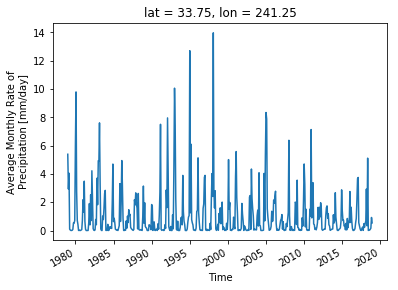

In [13]:
precip_da_irvine.plot()

**Take a rolling 3-month mean, with the window centered:**

In [14]:
precip_da_irvine_3mon_mean = precip_da_irvine.rolling(time=3, center=True).mean()

Next, let's pull out only the DJF averages.  We can use the rolling 3-month mean for this and make sure we only pull out the January values that represent the DJF means.

**To do this, loop through the ```time``` variable and create a list (of the same length) that has a 1 when it's January and a 0 otherwise.**  (Notice the *list comprehension* used:  it's a for loop embedded within a single line.)

In [15]:
# take the time axis and create a true/false array to pull out all January values
time_indices_jans = [t.month == 1 for t in time_values_converted]

**Plot ```time_da_jans``` to make sure we did it correctly:**

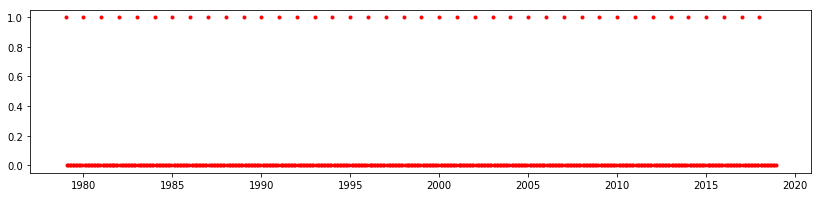

In [16]:
plt.plot(time_values,time_indices_jans,'.',c='red')
plt.gcf().set_size_inches(14,3)

**Use ```time_da_jans``` to subset both the times and the 3-month means.**  
Note the precip array has leftover lat/lon dimensions, so use ```.flatten()```:

In [17]:
precip_djf_3mon_means = precip_da_irvine_3mon_mean.values[time_indices_jans].flatten()
time_jans = time_values_converted[time_indices_jans]

Text(0, 0.5, 'mm day$^{-1}$')

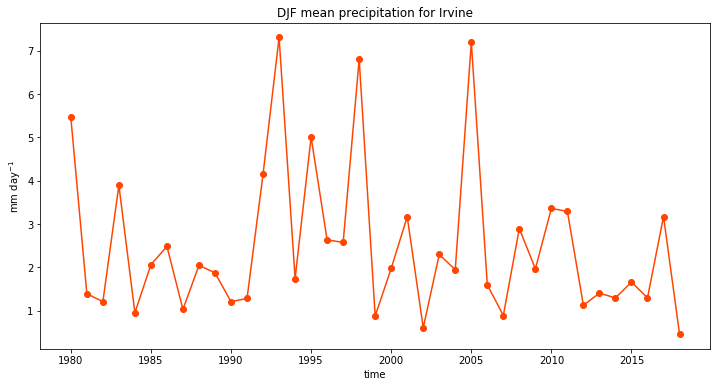

In [18]:
fig = plt.figure(figsize=(12,6)) # 12 in wide by 6 in tall

ax = fig.add_subplot(111)
ax.plot(time_jans, precip_djf_3mon_means,'o-',c='orangered')
ax.set_title('DJF mean precipitation for Irvine')
ax.set_xlabel('time')
ax.set_ylabel('mm day$^{-1}$')

# Key points

* **To open a NetCDF file, use [```xarray.open_dataset()```](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html)**
  * If you have a multi-file data set, you can also use [```xarray.open_mfdataset()```](http://xarray.pydata.org/en/stabl``e/generated/xarray.open_mfdataset.html)
  * This will intuitively concatenate along a dimension (typically time, or what you specify)


* **Pull out a dimension or data variable using the ```variable = dataset['name']``` syntax**
  * Do computations within xarray using syntax like ```variable.mean(dim='time')```
    * Most of the time, these calculations are done "lazily," meaning no actual computing will happen till you explicitly tell xarray to load the data set into memory using a ```.values``` or ```.compute()``` call
  * Do computations on the direct numpy array by first pulling out the data using ```variable.values```.  For example, ```numpy.mean(variable.values, axis=0)``` would take the mean across the time (zeroth) dimension.


* **xarray can do very straightforward parallel computing.  [See the documentation on using xarray with dask.](http://xarray.pydata.org/en/stable/dask.html)**